# Imports

In [1]:
%run local_functions.py
from local_functions import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re


from datasets import load_dataset
from datasets import Dataset, DatasetDict
from transformers import BertConfig, BertModel
from transformers import DistilBertConfig, DistilBertModel


from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AutoModelForTokenClassification

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
from transformers import TrainingArguments, Trainer


from sklearn.model_selection import train_test_split

plt.style.use("dark_background")

pd.set_option("display.max_columns", 2500)
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_colwidth", 50)


plt.style.use("dark_background")

%load_ext lab_black

2023-09-01 12:51:38.590024: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-01 12:51:38.610666: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 12:51:38.922069: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Preprocess

In [2]:
df = pd.read_parquet("datasets/amazon_reviews_multi-train.parquet")

df = df[["review_title", "review_body", "product_category"]]

for col in ["review_title", "review_body"]:
    df[col] = df[col].apply(text_normalization_2)
df["text"] = df["review_title"] + " " + df["review_body"]

df = df[["text", "product_category"]]

SAMPLE_SIZE = 10000

df_results = df[0:SAMPLE_SIZE]

df = df[0:SAMPLE_SIZE]

encoded_df = pd.get_dummies(
    df["product_category"], columns=["product_category"], prefix="", prefix_sep=""
)
encoded_df = encoded_df.astype(bool)
df = pd.concat([df["text"], encoded_df], axis=1)

In [3]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Convert the split DataFrames into Datasets
train = Dataset.from_pandas(train_df, split="train")
valid = Dataset.from_pandas(valid_df, split="validation")
test = Dataset.from_pandas(test_df, split="test")

dataset = DatasetDict({"train": train, "validation": valid, "test": test})

labels = [
    label
    for label in dataset["train"].features.keys()
    if label not in ["text", "__index_level_0__"]
]
id2label = {idx: label for idx, label in enumerate(labels)}
label2id = {label: idx for idx, label in enumerate(labels)}

# Tokenizer (Distilbert and Bert (RoBERTa too big for this GPU))

In [12]:
from transformers import MegatronBertConfig, MegatronBertModel

In [15]:
models_to_test = ["bert-base-uncased", "distilbert-base-uncased",]
model_n = 1

In [16]:
tokenizer = AutoTokenizer.from_pretrained(models_to_test[model_n])


def preprocess_data(examples):
    # take a batch of texts
    text = examples["text"]
    # encode them
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=256)
    # add labels
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(labels)))
    # fill numpy array
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]

    encoding["labels"] = labels_matrix.tolist()

    return encoding


encoded_dataset = dataset.map(
    preprocess_data, batched=True, remove_columns=dataset["train"].column_names
)

encoded_dataset.set_format("torch")

OSError: MegatronBertModel is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.

In [6]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 7000
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1500
    })
})

# Model

In [7]:
model = AutoModelForSequenceClassification.from_pretrained(
    models_to_test[model_n],
    problem_type="multi_label_classification",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
batch_size = 8
metric_name = "f1"

In [28]:
args = TrainingArguments(
    f"bert-finetuned-sem_eval-english",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    # push_to_hub=True,
)

In [29]:
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average="micro")
    roc_auc = roc_auc_score(y_true, y_pred, average="micro")
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {"f1": f1_micro_average, "roc_auc": roc_auc, "accuracy": accuracy}
    return metrics


def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    result = multi_label_metrics(predictions=preds, labels=p.label_ids)
    return result

In [30]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [31]:
trainer.train()

/home/luke/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/4375 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.1843, 'learning_rate': 1.7714285714285717e-05, 'epoch': 0.57}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.13266749680042267, 'eval_f1': 0.0, 'eval_roc_auc': 0.5, 'eval_accuracy': 0.0, 'eval_runtime': 8.8686, 'eval_samples_per_second': 169.135, 'eval_steps_per_second': 21.198, 'epoch': 1.0}
{'loss': 0.1329, 'learning_rate': 1.542857142857143e-05, 'epoch': 1.14}
{'loss': 0.129, 'learning_rate': 1.3142857142857145e-05, 'epoch': 1.71}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.12005826085805893, 'eval_f1': 0.0, 'eval_roc_auc': 0.5, 'eval_accuracy': 0.0, 'eval_runtime': 8.8641, 'eval_samples_per_second': 169.222, 'eval_steps_per_second': 21.209, 'epoch': 2.0}
{'loss': 0.1201, 'learning_rate': 1.0857142857142858e-05, 'epoch': 2.29}
{'loss': 0.1121, 'learning_rate': 8.571428571428571e-06, 'epoch': 2.86}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.11134834587574005, 'eval_f1': 0.10880195599022005, 'eval_roc_auc': 0.5291444444444444, 'eval_accuracy': 0.059333333333333335, 'eval_runtime': 8.9834, 'eval_samples_per_second': 166.975, 'eval_steps_per_second': 20.928, 'epoch': 3.0}
{'loss': 0.1036, 'learning_rate': 6.285714285714286e-06, 'epoch': 3.43}
{'loss': 0.0995, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.10677630454301834, 'eval_f1': 0.1725129384703853, 'eval_roc_auc': 0.5490111111111111, 'eval_accuracy': 0.1, 'eval_runtime': 9.0153, 'eval_samples_per_second': 166.384, 'eval_steps_per_second': 20.853, 'epoch': 4.0}
{'loss': 0.0926, 'learning_rate': 1.7142857142857145e-06, 'epoch': 4.57}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.1051199734210968, 'eval_f1': 0.1751740139211137, 'eval_roc_auc': 0.5495222222222222, 'eval_accuracy': 0.10066666666666667, 'eval_runtime': 8.9146, 'eval_samples_per_second': 168.264, 'eval_steps_per_second': 21.089, 'epoch': 5.0}
{'train_runtime': 775.8621, 'train_samples_per_second': 45.111, 'train_steps_per_second': 5.639, 'train_loss': 0.11928219691685268, 'epoch': 5.0}


TrainOutput(global_step=4375, training_loss=0.11928219691685268, metrics={'train_runtime': 775.8621, 'train_samples_per_second': 45.111, 'train_steps_per_second': 5.639, 'train_loss': 0.11928219691685268, 'epoch': 5.0})

In [35]:
trainer.evaluate()

  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.1051199734210968,
 'eval_f1': 0.1751740139211137,
 'eval_roc_auc': 0.5495222222222222,
 'eval_accuracy': 0.10066666666666667,
 'eval_runtime': 8.879,
 'eval_samples_per_second': 168.937,
 'eval_steps_per_second': 21.173,
 'epoch': 5.0}

In [37]:
# trainer.save_model("bert-finetuned-amazon-reviews-multi-train-10k")

# Distilbert 10k Eval - Training -> 6 min

In [16]:
model1 = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-finetuned-amazon-reviews-multi-train-10k"
)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

trainer1 = Trainer(model=model1, tokenizer=tokenizer)


id2label = load_pickel("label_dicts/id2label.pkl")

In [17]:
df = read_in_and_normalize("datasets/amazon_reviews_multi-test.parquet")
df_test = df[["text", "product_category"]]

/tmp/ipykernel_142542/1364755938.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["predicted_class"] = df_test["text"][:ROWS_TO_EVALUATE].apply(


Confidence Threshold: 0.1
Percent of predictions that include correct class: 54.1%
Multi_guess discount score: 47.27%
Multi_positive_outcome discount score: 54.74%
Confidence Threshold: 0.2
Percent of predictions that include correct class: 45.44%
Multi_guess discount score: 42.85%
Multi_positive_outcome discount score: 55.46%
Confidence Threshold: 0.3
Percent of predictions that include correct class: 40.1%
Multi_guess discount score: 38.99%
Multi_positive_outcome discount score: 63.92%
Confidence Threshold: 0.4
Percent of predictions that include correct class: 34.64%
Multi_guess discount score: 34.43%
Multi_positive_outcome discount score: 70.96%
Confidence Threshold: 0.5
Percent of predictions that include correct class: 28.46%
Multi_guess discount score: 28.45%
Multi_positive_outcome discount score: 79.38%
Confidence Threshold: 0.6
Percent of predictions that include correct class: 23.5%
Multi_guess discount score: 23.5%
Multi_positive_outcome discount score: 86.06%
Confidence Thr

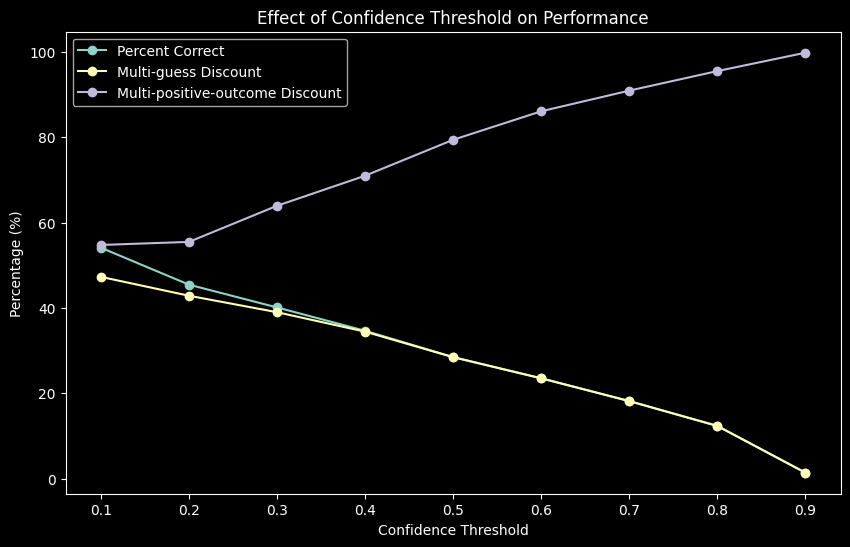

In [18]:
ROWS_TO_EVALUATE = len(df_test)
TOP_N_PREDS = 5

thresholds = []
percent_correct_list = []
percent_correct_discount_list = []
percent_correct_non_preds_list = []


for CONFIDENCE_THRESHOLD in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    df_test["predicted_class"] = df_test["text"][:ROWS_TO_EVALUATE].apply(
        predict_class, args=(tokenizer, trainer1, id2label, CONFIDENCE_THRESHOLD)
    )

    df_test["correct"] = df_test[:ROWS_TO_EVALUATE].apply(
        lambda row: int(row["product_category"] in row["predicted_class"]), axis=1
    )

    df_test["correct_w_discount"] = df_test[:ROWS_TO_EVALUATE].apply(
        multi_cat_guess_penalty, axis=1, args=(0.9,)
    )

    df_test["correct_w_non_preds"] = df_test.apply(multi_positive_outcome, axis=1)

    df_test["top_n_preds"] = df_test["text"][:ROWS_TO_EVALUATE].apply(
        n_most_likely_classes, args=(tokenizer, trainer1, id2label, TOP_N_PREDS)
    )

    percent_correct = (df_test["correct"].sum() / ROWS_TO_EVALUATE) * 100
    percent_correct_discount = (
        df_test["correct_w_discount"].sum() / ROWS_TO_EVALUATE
    ) * 100
    percent_correct_non_preds = (
        df_test["correct_w_non_preds"].sum() / ROWS_TO_EVALUATE
    ) * 100

    thresholds.append(CONFIDENCE_THRESHOLD)
    percent_correct_list.append(percent_correct)
    percent_correct_discount_list.append(percent_correct_discount)
    percent_correct_non_preds_list.append(percent_correct_non_preds)

    print(f"Confidence Threshold: {CONFIDENCE_THRESHOLD}")
    print(
        f"Percent of predictions that include correct class: {round(percent_correct, 2)}%"
    )
    print(f"Multi_guess discount score: {round(percent_correct_discount, 2)}%")
    print(
        f"Multi_positive_outcome discount score: {round(percent_correct_non_preds, 2)}%"
    )
    print("=" * 75)


plt.figure(figsize=(10, 6))
plt.plot(thresholds, percent_correct_list, marker="o", label="Percent Correct")
plt.plot(
    thresholds, percent_correct_discount_list, marker="o", label="Multi-guess Discount"
)
plt.plot(
    thresholds,
    percent_correct_non_preds_list,
    marker="o",
    label="Multi-positive-outcome Discount",
)
plt.xlabel("Confidence Threshold")
plt.ylabel("Percentage (%)")
plt.title("Effect of Confidence Threshold on Performance")
plt.legend()
plt.grid(False)
plt.show()

# Bert 10k Eval - Training -> 12 mins

In [38]:
model1 = AutoModelForSequenceClassification.from_pretrained(
    "bert-finetuned-amazon-reviews-multi-train-10k"
)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

trainer1 = Trainer(model=model1, tokenizer=tokenizer)


id2label = load_pickel("label_dicts/id2label.pkl")

In [39]:
df = read_in_and_normalize("datasets/amazon_reviews_multi-test.parquet")
df_test = df[["text", "product_category"]]

/tmp/ipykernel_142542/1364755938.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["predicted_class"] = df_test["text"][:ROWS_TO_EVALUATE].apply(


Confidence Threshold: 0.1
Percent of predictions that include correct class: 54.78%
Multi_guess discount score: 44.46%
Multi_positive_outcome discount score: 56.84%
Confidence Threshold: 0.2
Percent of predictions that include correct class: 38.28%
Multi_guess discount score: 36.55%
Multi_positive_outcome discount score: 65.08%
Confidence Threshold: 0.3
Percent of predictions that include correct class: 26.22%
Multi_guess discount score: 26.07%
Multi_positive_outcome discount score: 81.88%
Confidence Threshold: 0.4
Percent of predictions that include correct class: 18.56%
Multi_guess discount score: 18.56%
Multi_positive_outcome discount score: 90.36%
Confidence Threshold: 0.5
Percent of predictions that include correct class: 12.32%
Multi_guess discount score: 12.32%
Multi_positive_outcome discount score: 94.86%
Confidence Threshold: 0.6
Percent of predictions that include correct class: 8.5%
Multi_guess discount score: 8.5%
Multi_positive_outcome discount score: 97.58%
Confidence Thr

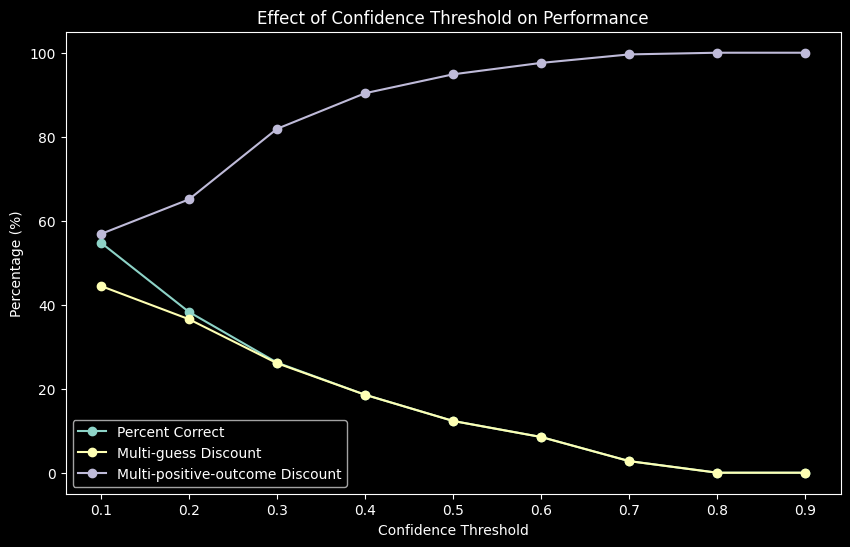

In [40]:
ROWS_TO_EVALUATE = len(df_test)
TOP_N_PREDS = 5

thresholds = []
percent_correct_list = []
percent_correct_discount_list = []
percent_correct_non_preds_list = []


for CONFIDENCE_THRESHOLD in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    df_test["predicted_class"] = df_test["text"][:ROWS_TO_EVALUATE].apply(
        predict_class, args=(tokenizer, trainer1, id2label, CONFIDENCE_THRESHOLD)
    )

    df_test["correct"] = df_test[:ROWS_TO_EVALUATE].apply(
        lambda row: int(row["product_category"] in row["predicted_class"]), axis=1
    )

    df_test["correct_w_discount"] = df_test[:ROWS_TO_EVALUATE].apply(
        multi_cat_guess_penalty, axis=1, args=(0.9,)
    )

    df_test["correct_w_non_preds"] = df_test.apply(multi_positive_outcome, axis=1)

    df_test["top_n_preds"] = df_test["text"][:ROWS_TO_EVALUATE].apply(
        n_most_likely_classes, args=(tokenizer, trainer1, id2label, TOP_N_PREDS)
    )

    percent_correct = (df_test["correct"].sum() / ROWS_TO_EVALUATE) * 100
    percent_correct_discount = (
        df_test["correct_w_discount"].sum() / ROWS_TO_EVALUATE
    ) * 100
    percent_correct_non_preds = (
        df_test["correct_w_non_preds"].sum() / ROWS_TO_EVALUATE
    ) * 100

    thresholds.append(CONFIDENCE_THRESHOLD)
    percent_correct_list.append(percent_correct)
    percent_correct_discount_list.append(percent_correct_discount)
    percent_correct_non_preds_list.append(percent_correct_non_preds)

    print(f"Confidence Threshold: {CONFIDENCE_THRESHOLD}")
    print(
        f"Percent of predictions that include correct class: {round(percent_correct, 2)}%"
    )
    print(f"Multi_guess discount score: {round(percent_correct_discount, 2)}%")
    print(
        f"Multi_positive_outcome discount score: {round(percent_correct_non_preds, 2)}%"
    )
    print("=" * 75)


plt.figure(figsize=(10, 6))
plt.plot(thresholds, percent_correct_list, marker="o", label="Percent Correct")
plt.plot(
    thresholds, percent_correct_discount_list, marker="o", label="Multi-guess Discount"
)
plt.plot(
    thresholds,
    percent_correct_non_preds_list,
    marker="o",
    label="Multi-positive-outcome Discount",
)
plt.xlabel("Confidence Threshold")
plt.ylabel("Percentage (%)")
plt.title("Effect of Confidence Threshold on Performance")
plt.legend()
plt.grid(False)
plt.show()